<a href="https://colab.research.google.com/github/itchyfeet-patient/Going_Deeper/blob/master/Cutmix_Mixup_Comparative_Experiment/%5BGD_2%5DData_Augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **[GD_2] Project : CutMix 또는 Mixup 비교실험 하기 🌄**

Augmentation은 한정된 데이터셋을 여러가지 방법으로 증강시켜(augment) 실질적인 학습 데이터셋의 규모를 키울 수 있는 방법입니다.  
* 과적합(overfitting) 방지
* 기 보유 데이터셋이 실제 상황에서의 입력값과 다른 경우 실제 입력값과 비슷한 데이터분포를 만들어 낼 수 있음  

## Augmentation의 종류
* Flipping
* Gray Scale
* Saturation
* Brightness
* Rotation
* Center crop
* Blurring
* RandomCrop
* ...

In [2]:
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import albumentations as A

print(tf.__version__)
print(np.__version__)

2.8.2
1.21.6


## **0. Data 불러오기**

stanford_dogs 데이터셋을 사용해보겠습니다.  
[stanford_dogs 데이터셋](https://www.tensorflow.org/datasets/catalog/stanford_dogs)  
* 120개 견종의 이미지
* 총 20,580장의 이미지
* 학습 데이터셋 12,000장
* 평가 데이터셋 8,580장


In [3]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    #as_supervised=True,
    shuffle_files=True,
    with_info=True,
)
num_classes = ds_info.features["label"].num_classes

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/12000 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/stanford_dogs/0.2.0.incompleteAYTE8K/stanford_dogs-train.tfrecord*...:   0%|  …

Generating test examples...:   0%|          | 0/8580 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/stanford_dogs/0.2.0.incompleteAYTE8K/stanford_dogs-test.tfrecord*...:   0%|   …

Dataset stanford_dogs downloaded and prepared to ~/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.


다운로드된 데이터 확인

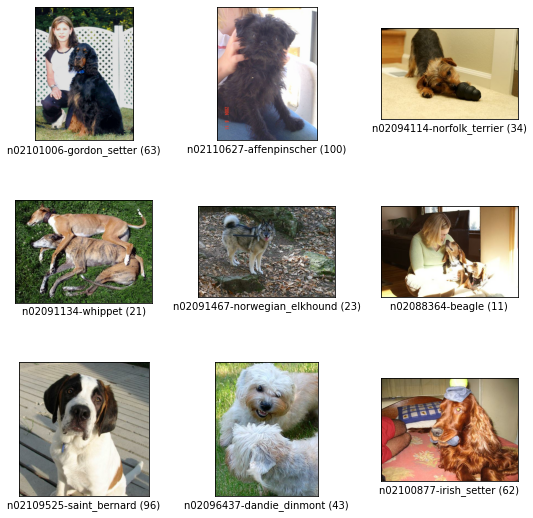

In [4]:
fig=tfds.show_examples(ds_train, ds_info)

## **1. Augmentation을 적용한 데이터셋 만들기**
이전 스텝과 아래 코드를 참고하여 데이터셋에 CutMix 또는 Mixup augmentation을 적용해 주세요.

```
Q1. 아래는 CutMix를 적용할 수 있도록 변경한 apply_normalize_on_dataset()입니다.
batch() 함수 뒤에 CutMix가 오도록 만들어야합니다. 그 이유가 뭘까요?

👉 CutMix는 배치 안에 있는 이미지끼리만 섞는 과정이기 때문에, 미리 배치 단위로 데이터셋을 정렬 후 CutMix가 적용되어야 합니다.
```

### cutmix 함수 구현

In [5]:
# 바운딩 박스 위치 결정함수
# 바탕이미지 image_a, 다른이미지 image_b
def get_clip_box(image_a, image_b, image_size=224):
    # image.shape = (height, width, channel)

    # get center of box
    x = tf.cast(tf.random.uniform([], 0, image_size), tf.int32)
    y = tf.cast(tf.random.uniform([], 0, image_size), tf.int32)

    # get width.. height = width니까
    _prob = tf.random.uniform([],0,1)
    width = tf.cast(image_size*tf.math.sqrt(1-_prob), tf.int32)
    
    # clip box in image and get minmax bbox
    x_min = tf.math.maximum(0, x-width//2)
    y_min = tf.math.maximum(0, y-width//2)
    x_max = tf.math.minimum(image_size, x+width//2)
    y_max = tf.math.minimum(image_size, y+width//2)
    
    return x_min, y_min, x_max, y_max


In [6]:
# mix two images
# get_clip_box에서 가져온 변수값들을 이용해서 image 섞기
def mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max, image_size=224):
    middle_left = image_a[y_min:y_max, 0:x_min, :] # image_b의 왼쪽 바깥 영역
    middle_center = image_b[y_min:y_max, x_min:x_max, :]  # image_b의 안쪽 영역
    middle_right = image_a[y_min:y_max, x_max:image_size, :] # image_b의 오른쪽 바깥 영역
    middle = tf.concat([middle_left,middle_center,middle_right], axis=1)
    top = image_a[0:y_min, :, :]
    bottom = image_a[y_max:image_size, :, :]
    mixed_img = tf.concat([top, middle, bottom],axis=0)
    
    return mixed_img

In [7]:
# mix two labels
# 이미지 섞었으니까 라벨도 적절한 비율로 섞어주기
def mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max, num_classes=120, image_size=224):
    mixed_area = (x_max-x_min)*(y_max-y_min)
    total_area = image_size*image_size
    ratio = tf.cast(mixed_area/total_area, tf.float32)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-ratio)*label_a + ratio*label_b
    return mixed_label


In [8]:
# 위의 두 함수를 이용해서 배치단위의 cutmix 함수를 구현
def cutmix(image, label, prob=1.0, batch_size=16, image_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max))
        mixed_labels.append(mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, image_size, image_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels


### mixup 함수 구현

mixup은 cutmix와 다르게 픽셀값을 비율에 따라 섞어주는 방식

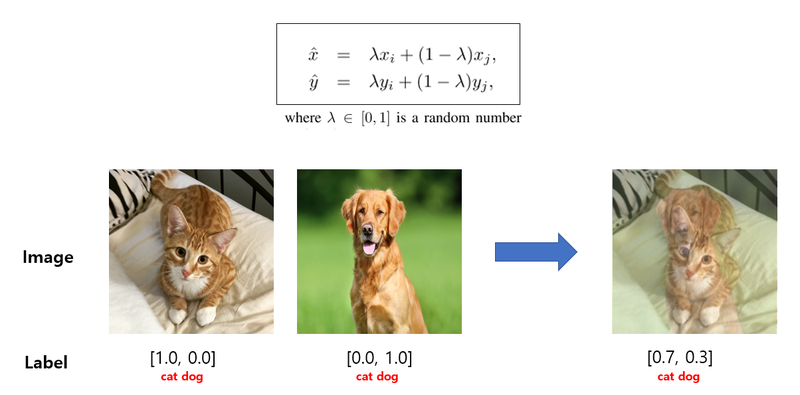

In [9]:
# function for mixup
def mixup_2_images(image_a, image_b, label_a, label_b):
    ratio = tf.random.uniform([], 0, 1)
    
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image= (1-ratio)*image_a + ratio*image_b
    mixed_label = (1-ratio)*label_a + ratio*label_b
    
    return mixed_image, mixed_label


In [10]:
def mixup(image, label, prob=1.0, batch_size=16, image_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0,batch_size), tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, image_size, image_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels


### Augmentation 함수

In [11]:
# normalize & resize 함수
def normalize_and_resize_img(image, label):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

# 반전, 밝기조절 적용 함수
def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    return image, label

# 라벨을 클래스 개수만큼 one-hot encoding해줌
def onehot(image, label):
    label = tf.one_hot(label, num_classes)
    return image, label

print('=3')

=3


In [12]:
# dataset에 test인지, augmentation 적용할지, cutmix 적용할지 함수
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False, with_cutmix=False, with_mixup=False):
    ds = ds.map(
        # normalize & resize 함수 적용 
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    # train 데이터에만 augmentation 적용
    if not is_test and with_aug:
        ds = ds.map(
            # augment 함수 적용
            augment,
            num_parallel_calls=2
        )
    # batch 함수
    ds = ds.batch(batch_size)

    # batch함수 뒤에 cutmix온당~

    # train데이터면서 cutmix 적용시
    if not is_test and with_cutmix:
        ds = ds.map(
            # cutmix 적용
            cutmix,
            num_parallel_calls=2
        )
    elif not is_test and with_mixup:
        ds = ds.map(
            # cutmix 적용
            mixup,
            num_parallel_calls=2
        )
    else:
        # test데이터
        ds = ds.map(
            # onehot 적용
            onehot,
            num_parallel_calls=2
        )
    if not is_test:
        # train 데이터
        ds = ds.repeat()
        ds = ds.shuffle(200)
        
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds


## **2. 모델 만들기**
앞서 만들었던 것처럼 비교 실험을 위한 모델 두 개를 만들어 주세요. 모델은 ResNet-50을 사용합시다.

**no augmentation** 적용한 데이터셋으로 학습시킬 resnet50

In [13]:
no_aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        # FC layer 포함안함
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])
print('=3')

94781440/94765736 [==============================] - 0s 0us/step
=3


**기본 augmentation** 적용한 데이터셋으로 학습시킬 resnet50

In [14]:
aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])
print('=3')

=3


**기본+cutmix** 적용한 데이터셋으로 학습시킬 resnet50

In [15]:
aug_cutmix_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])
print('=3')

=3


**기본+mixup** 적용한 데이터셋으로 학습시킬 resnet50

In [16]:
aug_mixup_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])
print('=3')

=3


**no aug + cutmix** 적용한 데이터셋으로 학습시킬 resnet50

In [17]:
no_aug_cutmix_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])
print('=3')

=3


**no aug + mixup** 적용한 데이터셋으로 학습시킬 resnet50

In [18]:
no_aug_mixup_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])
print('=3')

=3


## **3. 모델 훈련하기**
모델을 훈련시켜 주세요.

주의!! 위에서 만든 CutMix나 Mixup을 사용하기 위해서는 앞에서 resnet50과 aug_resnet50을 훈련하는 데 사용했던 sparse_categorical_crossentropy() 대신 categorical_crossentropy()를 사용해 주세요!

```
Q2. sparse_categorical_crossentropy()를 사용하지 못하는 이유가 뭘까요?

👉 우리가 cutmix(), mixup()을 구현하면서 label의 mix 때문에 
더이상 label이 스칼라값을 가지지 못하고 One-Hot 벡터 형태로 변환되었기 때문
```

텐서플로우 데이터셋에서 불러온 데이터에 apply_normalize_on_dataset()에서 with_aug를 False로 주면 aug적용x, True로 주면 aug 적용o를 이용하겠습니다.
1. augmentation 적용x  
2. 기본 augmentation 적용o
3. 기본 + cutmix
4. 기본 + mixup

In [19]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)
ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False)
ds_train_aug = apply_normalize_on_dataset(ds_train, with_aug=True)
ds_train_aug_cutmix = apply_normalize_on_dataset(ds_train, with_aug=True, with_cutmix=True)
ds_train_aug_mixup = apply_normalize_on_dataset(ds_train, with_aug=True, with_mixup=True)
ds_test = apply_normalize_on_dataset(ds_test, is_test=True)
ds_train_no_aug_cutmix = apply_normalize_on_dataset(ds_train, with_aug=False, with_cutmix=True)
ds_train_no_aug_mixup = apply_normalize_on_dataset(ds_train, with_aug=False, with_mixup=True)
print('=3')

=3


훈련 돌입~

**기본 aug**

In [20]:
EPOCH = 20

aug_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_aug = aug_resnet50.fit(
    ds_train_aug, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


750/750 [==============================] - 108s 119ms/step - loss: 2.2547 - accuracy: 0.4313 - val_loss: 3.0827 - val_accuracy: 0.2613
Epoch 2/20
750/750 [==============================] - 88s 117ms/step - loss: 0.8914 - accuracy: 0.7437 - val_loss: 1.1972 - val_accuracy: 0.6512
Epoch 3/20
750/750 [==============================] - 93s 124ms/step - loss: 0.4882 - accuracy: 0.8632 - val_loss: 1.1102 - val_accuracy: 0.6765
Epoch 4/20
750/750 [==============================] - 88s 118ms/step - loss: 0.2278 - accuracy: 0.9468 - val_loss: 1.0251 - val_accuracy: 0.7091
Epoch 5/20
750/750 [==============================] - 88s 117ms/step - loss: 0.1099 - accuracy: 0.9803 - val_loss: 0.9328 - val_accuracy: 0.7364
Epoch 6/20
750/750 [==============================] - 88s 118ms/step - loss: 0.0607 - accuracy: 0.9922 - val_loss: 0.9162 - val_accuracy: 0.7464
Epoch 7/20
750/750 [==============================] - 93s 124ms/step - loss: 0.0389 - accuracy: 0.9956 - val_loss: 1.1356 - val_accuracy: 0.

**no aug**

In [21]:
EPOCH = 20

no_aug_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_no_aug = no_aug_resnet50.fit(
    ds_train_no_aug, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 95s 118ms/step - loss: 2.2302 - accuracy: 0.4426 - val_loss: 3.2143 - val_accuracy: 0.2290
Epoch 2/20
750/750 [==============================] - 88s 117ms/step - loss: 0.6911 - accuracy: 0.8148 - val_loss: 1.0730 - val_accuracy: 0.6839
Epoch 3/20
750/750 [==============================] - 88s 117ms/step - loss: 0.1940 - accuracy: 0.9618 - val_loss: 0.9623 - val_accuracy: 0.7165
Epoch 4/20
750/750 [==============================] - 88s 117ms/step - loss: 0.0493 - accuracy: 0.9958 - val_loss: 0.9153 - val_accuracy: 0.7329
Epoch 5/20
750/750 [==============================] - 88s 118ms/step - loss: 0.0196 - accuracy: 0.9997 - val_loss: 0.9193 - val_accuracy: 0.7379
Epoch 6/20
750/750 [==============================] - 88s 117ms/step - loss: 0.0159 - accuracy: 0.9997 - val_loss: 0.9513 - val_accuracy: 0.7352
Epoch 7/20
750/750 [==============================] - 86s 115ms/step - loss: 0.0378 - accuracy: 0.9969 - val_loss: 0.9857 - val_ac

**기본 + cutmix**

In [22]:
EPOCH = 20

aug_cutmix_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_aug_cutmix = aug_cutmix_resnet50.fit(
    ds_train_aug_cutmix, # 기본 aug + cutmix
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 97s 119ms/step - loss: 3.8437 - accuracy: 0.2091 - val_loss: 3.0227 - val_accuracy: 0.2507
Epoch 2/20
750/750 [==============================] - 88s 118ms/step - loss: 2.9638 - accuracy: 0.4243 - val_loss: 1.4612 - val_accuracy: 0.5960
Epoch 3/20
750/750 [==============================] - 88s 118ms/step - loss: 2.6911 - accuracy: 0.5004 - val_loss: 1.2481 - val_accuracy: 0.6489
Epoch 4/20
750/750 [==============================] - 88s 118ms/step - loss: 2.5240 - accuracy: 0.5608 - val_loss: 1.1205 - val_accuracy: 0.6841
Epoch 5/20
750/750 [==============================] - 88s 118ms/step - loss: 2.3645 - accuracy: 0.6106 - val_loss: 1.1904 - val_accuracy: 0.6635
Epoch 6/20
750/750 [==============================] - 88s 117ms/step - loss: 2.2692 - accuracy: 0.6404 - val_loss: 1.1840 - val_accuracy: 0.6727
Epoch 7/20
750/750 [==============================] - 88s 118ms/step - loss: 2.1506 - accuracy: 0.6691 - val_loss: 1.1419 - val_ac

**기본 + mixup**

In [23]:
EPOCH = 20

aug_mixup_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_aug_mixup = aug_mixup_resnet50.fit(
    ds_train_aug_mixup, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 97s 119ms/step - loss: 3.7495 - accuracy: 0.2353 - val_loss: 3.6829 - val_accuracy: 0.1802
Epoch 2/20
750/750 [==============================] - 88s 118ms/step - loss: 2.8922 - accuracy: 0.4614 - val_loss: 1.8167 - val_accuracy: 0.5049
Epoch 3/20
750/750 [==============================] - 88s 118ms/step - loss: 2.6368 - accuracy: 0.5537 - val_loss: 1.3678 - val_accuracy: 0.6260
Epoch 4/20
750/750 [==============================] - 89s 118ms/step - loss: 2.4609 - accuracy: 0.6234 - val_loss: 1.3297 - val_accuracy: 0.6307
Epoch 5/20
750/750 [==============================] - 89s 119ms/step - loss: 2.3696 - accuracy: 0.6592 - val_loss: 1.3859 - val_accuracy: 0.6217
Epoch 6/20
750/750 [==============================] - 90s 120ms/step - loss: 2.2847 - accuracy: 0.6990 - val_loss: 1.1779 - val_accuracy: 0.6764
Epoch 7/20
750/750 [==============================] - 90s 120ms/step - loss: 2.1924 - accuracy: 0.7276 - val_loss: 1.3067 - val_ac

**No aug + cutmix**

In [24]:
EPOCH = 20

no_aug_cutmix_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_no_aug_cutmix = no_aug_cutmix_resnet50.fit(
    ds_train_no_aug_cutmix, # no aug + cutmix
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 95s 119ms/step - loss: 3.8225 - accuracy: 0.2128 - val_loss: 3.3831 - val_accuracy: 0.1947
Epoch 2/20
750/750 [==============================] - 88s 118ms/step - loss: 2.8903 - accuracy: 0.4424 - val_loss: 1.4054 - val_accuracy: 0.6098
Epoch 3/20
750/750 [==============================] - 89s 119ms/step - loss: 2.5961 - accuracy: 0.5402 - val_loss: 1.2469 - val_accuracy: 0.6516
Epoch 4/20
750/750 [==============================] - 89s 119ms/step - loss: 2.3850 - accuracy: 0.6115 - val_loss: 1.2451 - val_accuracy: 0.6617
Epoch 5/20
750/750 [==============================] - 90s 120ms/step - loss: 2.2037 - accuracy: 0.6637 - val_loss: 1.1668 - val_accuracy: 0.6807
Epoch 6/20
750/750 [==============================] - 89s 119ms/step - loss: 2.0963 - accuracy: 0.6976 - val_loss: 1.3270 - val_accuracy: 0.6469
Epoch 7/20
750/750 [==============================] - 89s 118ms/step - loss: 2.0161 - accuracy: 0.7217 - val_loss: 1.2608 - val_ac

**No aug + mixup**

In [25]:
EPOCH = 20

no_aug_mixup_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_no_aug_mixup = no_aug_mixup_resnet50.fit(
    ds_train_no_aug_mixup, # no aug + mixup
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 101s 126ms/step - loss: 3.7312 - accuracy: 0.2426 - val_loss: 3.6745 - val_accuracy: 0.1681
Epoch 2/20
750/750 [==============================] - 88s 118ms/step - loss: 2.8492 - accuracy: 0.4799 - val_loss: 1.6202 - val_accuracy: 0.5563
Epoch 3/20
750/750 [==============================] - 89s 118ms/step - loss: 2.5869 - accuracy: 0.5857 - val_loss: 1.5174 - val_accuracy: 0.5870
Epoch 4/20
750/750 [==============================] - 89s 118ms/step - loss: 2.4034 - accuracy: 0.6509 - val_loss: 1.2580 - val_accuracy: 0.6441
Epoch 5/20
750/750 [==============================] - 89s 118ms/step - loss: 2.2235 - accuracy: 0.7136 - val_loss: 1.5256 - val_accuracy: 0.5912
Epoch 6/20
750/750 [==============================] - 89s 119ms/step - loss: 2.1579 - accuracy: 0.7437 - val_loss: 1.3257 - val_accuracy: 0.6439
Epoch 7/20
750/750 [==============================] - 91s 121ms/step - loss: 2.0559 - accuracy: 0.7795 - val_loss: 1.3749 - val_a

## **4. 훈련 과정 시각화하기**
훈련 과정의 히스토리를 그래프로 시각화해 주세요.

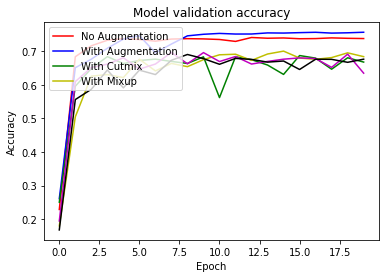

In [39]:
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.plot(history_resnet50_aug_cutmix.history['val_accuracy'], 'g')
plt.plot(history_resnet50_aug_mixup.history['val_accuracy'], 'y')
plt.plot(history_resnet50_no_aug_cutmix.history['val_accuracy'], 'm')
plt.plot(history_resnet50_no_aug_mixup.history['val_accuracy'], 'k')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation','With Cutmix','With Mixup','With No Aug and Cutmix','With No Aug and mixup'], loc='upper left')
plt.show()

조금 더 확대해 살펴봅시다

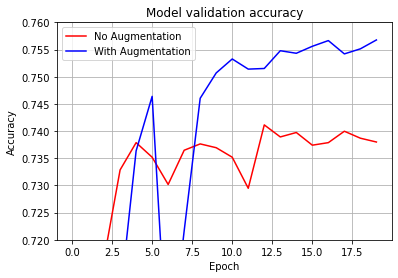

In [27]:
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.plot(history_resnet50_aug_cutmix.history['val_accuracy'], 'g')
plt.plot(history_resnet50_aug_mixup.history['val_accuracy'], 'y')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation'], loc='upper left')
plt.grid(True)
plt.ylim(0.72, 0.76)  # EPOCH=20으로 진행한다면 이 범위가 적당합니다. 
plt.show()

No Augmentation 모델보다 Augmentation을 준 모델이 accuracy가 더 높습니다~!

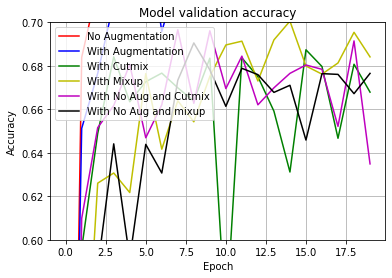

In [49]:
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.plot(history_resnet50_aug_cutmix.history['val_accuracy'], 'g')
plt.plot(history_resnet50_aug_mixup.history['val_accuracy'], 'y')
plt.plot(history_resnet50_no_aug_cutmix.history['val_accuracy'], 'm')
plt.plot(history_resnet50_no_aug_mixup.history['val_accuracy'], 'k')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation','With Cutmix','With Mixup','With No Aug and Cutmix','With No Aug and mixup'], loc='upper left')
plt.grid(True)
#plt.xlim(0.72, 0.76)
plt.ylim(0.6, 0.7)  # EPOCH=20으로 진행한다면 이 범위가 적당합니다. 
plt.show()

전혀 못알아보겠네요? 밑에서 더 자세히 알아봅시다.

### **cutmix VS mixup (With Augmentation)**

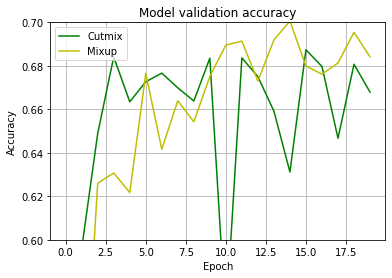

In [50]:
plt.plot(history_resnet50_aug_cutmix.history['val_accuracy'], 'g')
plt.plot(history_resnet50_aug_mixup.history['val_accuracy'], 'y')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Cutmix', 'Mixup'], loc='upper left')
plt.grid(True)
#plt.xlim(0.72, 0.76)
plt.ylim(0.6, 0.7)  # EPOCH=20으로 진행한다면 이 범위가 적당합니다. 
plt.show()

학습 초반에는 cutmix 성능이 우세하다가, 학습 후반부에는 mixup의 성능이 더 높게 나왔습니다.

### **Aug + cutmix VS No Aug + cutmix**

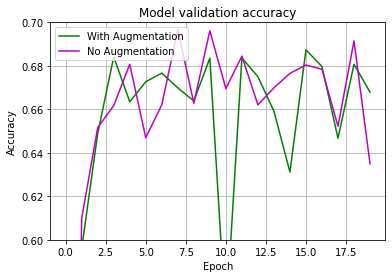

In [41]:
plt.plot(history_resnet50_aug_cutmix.history['val_accuracy'], 'g')
plt.plot(history_resnet50_no_aug_cutmix.history['val_accuracy'], 'm')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['With Augmentation', 'No Augmentation'], loc='upper left')
plt.grid(True)
#plt.xlim(0.72, 0.76)
plt.ylim(0.6, 0.7)  # EPOCH=20으로 진행한다면 이 범위가 적당합니다. 
plt.show()

사실 우열을 가릴 수 없어 보입니다. 

### **Aug + mixup VS No Aug + mixup**

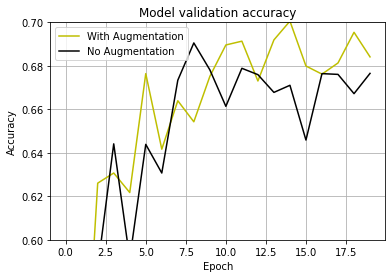

In [43]:
plt.plot(history_resnet50_aug_mixup.history['val_accuracy'], 'y')
plt.plot(history_resnet50_no_aug_mixup.history['val_accuracy'], 'k')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['With Augmentation', 'No Augmentation'], loc='upper left')
plt.grid(True)
#plt.xlim(0.72, 0.76)
plt.ylim(0.6, 0.7)  # EPOCH=20으로 진행한다면 이 범위가 적당합니다. 
plt.show()

mixup에서는 augmentation을 한 mixup모델이 더 accuracy가 높게 나왔습니다.

## **5. Augmentation에 의한 모델 성능 비교**
No Augmentation, 기본 Augmentation, 기본 + CutMix 적용, 기본 + Mixup 적용 이상 4가지 경우의 데이터셋에 대해 훈련된 ResNet50 분류기의 견종 분류 정확도 성능을 비교해 보고, Augmentation 방법들의 영향도에 대해 분석해 보세요.

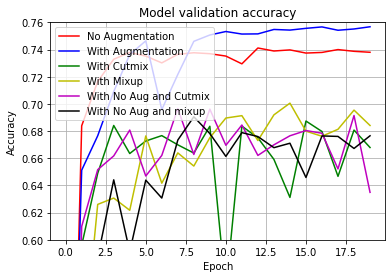

In [45]:
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.plot(history_resnet50_aug_cutmix.history['val_accuracy'], 'g')
plt.plot(history_resnet50_aug_mixup.history['val_accuracy'], 'y')
plt.plot(history_resnet50_no_aug_cutmix.history['val_accuracy'], 'm')
plt.plot(history_resnet50_no_aug_mixup.history['val_accuracy'], 'k')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation','With Cutmix','With Mixup','With No Aug and Cutmix','With No Aug and mixup'], loc='upper left')
plt.grid(True)
plt.ylim(0.60, 0.76)
plt.show()

* Augmentation을 적용한 모델이 더 정확도가 높았다. (파란색/빨간색)
* cutmix와 mixup 중에서는 mixup 성능이 더 높았다. (노랑/초록)
* mixup에서 augmentation의 적용 유무를 또 다르게 해보았는데, augmentation을 적용한 모델이 더 정확도가 높았다. (노랑/검정)

In [46]:
print(f"No Augmentation best accuracy : {round(max(history_resnet50_no_aug.history['val_accuracy']), 3)}")
print(f"With Augmentation best accuracy : {round(max(history_resnet50_aug.history['val_accuracy']), 3)}")
print(f"With Augmentation with Cutmix best accuracy : {round(max(history_resnet50_aug_cutmix.history['val_accuracy']), 3)}")
print(f"With Augmentation with mixup best accuracy : {round(max(history_resnet50_aug_mixup.history['val_accuracy']), 3)}")
print(f"No Augmentation with cutmix best accuracy : {round(max(history_resnet50_no_aug_cutmix.history['val_accuracy']), 3)}")
print(f"No Augmentation with mixup best accuracy : {round(max(history_resnet50_no_aug_mixup.history['val_accuracy']), 3)}")

No Augmentation best accuracy : 0.741
With Augmentation best accuracy : 0.757
With Augmentation with Cutmix best accuracy : 0.687
With Augmentation with mixup best accuracy : 0.701
No Augmentation with cutmix best accuracy : 0.697
No Augmentation with mixup best accuracy : 0.691


|  | No Augmentation | With Augmentation |
|:---:|:---:|:---:|
| No CutMix, MixUp | 0.741 | 0.757 |
| With CutMix | 0.697 | 0.687 |
| With MixUp | 0.691 | 0.701 |

그래프에서 가장 높은 수치만 가져와서 표를 그려봤다.  


---

### **🌮 루브릭**
| **평가문항** 	| **상세기준** 	| **수행결과** 	|
|:---:	|:---:	|:---:	|
| 1. CutMix와 MixUp 기법을 ResNet50 분류기에 성공적으로 적용하였는가? 	| CutMix와 MixUp을 적용한 데이터셋으로 훈련한 각각의 ResNet 모델이 수렴하였다. 	| O 	|
| 2. 다양한 실험을 통해 태스크에 최적인 Augmentation 기법을 찾아내었는가? 	| 각 Augmentation 기법을 적용하고, 그에 따른 성능 비교 분석 및 문제점을 서술하였음 	| O 	|
| 3. 여러가지 Augmentation 기법을 적용한 결과를 체계적으로 비교분석하였는가? 	| 기본 Augmentation, CutMix, MixUp이 적용된 결과를 시각화와 함께 체계적으로 분석하였다. 	| O 	|

### **✍ 회고**

* 확실히 augmentation을 적용한 모델의 성능이 좋은 경향이 있다는 사실을 볼 수 있는 실험이었다. keras로 하는 방법에는 한계가 있어서, 실습에서 배운 다른 방법을 숙지하는게 프로젝트 시 도움되어 보인다. [참고](https://github.com/aleju/imgaug)

* 정말 바보같은 실수로 거의 이틀을 날린것 같다.. img_size=224로 지정해놓고 정작 함수내에는 image_size 라고 적어놔서...... 사이즈가 계속 안맞다고 부르짖었는데 나는 다른데에 문제가 있나.. 애꿎은 tf.cast를 바꿔보고 힘들었따...

* 저 위에 표를 그리고 나니 no augmentation + mixup / cutmix 도 해볼까 싶어서 조금 코드를 수정하고 다시 돌려봤다.
* cutmix가 mixup보다 성능 좋았는데 반전됐다... 어떻게 된 일일까나
* augmentation 하는 방법은 여러가지 있는데 그 방법들마다 input형식 output 형식을 고려해야 된다는 점이 매우 까다로웠다. 코딩이 힘들다.. 

### **📚 참고문헌**

* [[kaggle]CutMix and MixUp on GPU/TPU](https://www.kaggle.com/code/cdeotte/cutmix-and-mixup-on-gpu-tpu/notebook)
* [cutmix구현](https://github.com/JaeHeee/AIFFEL_Project/blob/master/Going_Deeper/CutMix%20and%20MixUp.ipynb)